In [1]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [2]:
pip install konlpy

# 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import urllib.request

from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
                           filename="ratings_train.txt")

('ratings_train.txt', <http.client.HTTPMessage at 0x7a619b3b2650>)

In [5]:
df = pd.read_csv('ratings_train.txt',sep='\t')

In [6]:
print('훈련 샘플의 개수 :',len(df)) # 훈련용 리뷰 개수 출력

훈련 샘플의 개수 : 150000


In [7]:
df = df[:20000]

In [8]:
df.head() # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
df.tail()

,id,document,label
19995,8558198,커스턴양은 어려서나 지금이나 얼굴이 똑같네.,0
19996,8211203,초반부는 좋았는데 끝으로 갈수록 이건 뭐 코미디도 아니고...끝부분은 너무 유치했다...,0
19997,9396150,작가야 왜 사냐~!!!!,0
19998,325444,내가 본 한국영화 top10에 들어감!!,1
19999,9855901,어릴때봣엇지만매우재밋엇다,1


In [10]:
df['label'].unique()

array([0, 1])

In [11]:
# document 열에서 중복인 내용이 있다면 중복 제거
df.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(df))

총 샘플의 수 : 19754


In [12]:
print('총 샘플의 수 :',len(df))

총 샘플의 수 : 19754


In [13]:
df['document'].nunique(), df['label'].nunique()

(19754, 2)

<Axes: xlabel='label'>

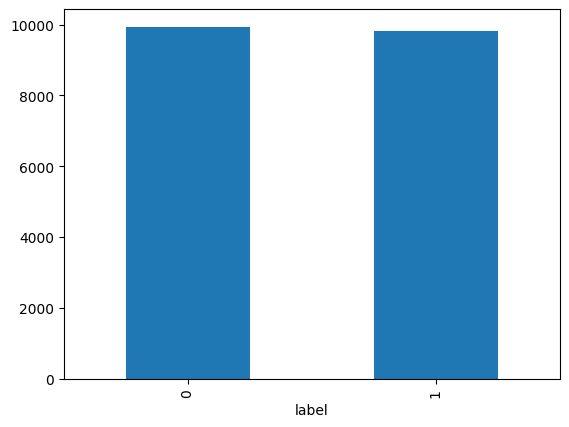

In [14]:
df['label'].value_counts().plot(kind = 'bar')

In [15]:
print(df.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   9935
1      1   9819


- 한글과 공백을 제외하고 모두 제거

In [16]:
df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- white space 데이터를 empty value로 변경

In [17]:
df['document'] = df['document'].str.replace('^ +', "")
df['document'].replace('', np.nan, inplace=True)
print(df.isnull().sum())
df.head()

id          0
document    0
label       0
dtype: int64


<ipython-input-17-29f3cff6b2f1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['document'].replace('', np.nan, inplace=True)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [18]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [19]:
okt = Okt()

- 불용어 제거
- 토큰화

In [20]:
df_token = []
for sentence in tqdm(df['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    ss = [word for word in tokenized_sentence if not word in stopwords]
    df_token.append(ss)

100%|██████████| 19754/19754 [01:11<00:00, 275.16it/s]


In [21]:
print('전처리 후 테스트용 샘플의 개수 :',len(df_token))

전처리 후 테스트용 샘플의 개수 : 19754


In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_token)
print(tokenizer.word_index)

{'.': 1, '영화': 2, '보다': 3, '..': 4, '을': 5, '...': 6, ',': 7, '없다': 8, '이다': 9, '있다': 10, '좋다': 11, '?': 12, '너무': 13, '다': 14, '정말': 15, '재밌다': 16, '만': 17, '적': 18, '되다': 19, '같다': 20, '진짜': 21, '!': 22, '아니다': 23, '점': 24, '로': 25, '않다': 26, '에서': 27, '만들다': 28, '나오다': 29, '연기': 30, '평점': 31, '것': 32, '최고': 33, '나': 34, '안': 35, '내': 36, '~': 37, '인': 38, '그': 39, '왜': 40, '못': 41, '스토리': 42, '....': 43, '사람': 44, '생각': 45, '드라마': 46, '보고': 47, '감동': 48, '1': 49, '이렇다': 50, '게': 51, '고': 52, '아깝다': 53, '때': 54, '말': 55, '감독': 56, '더': 57, '아': 58, '그냥': 59, 'ㅋㅋ': 60, '거': 61, '요': 62, '재미': 63, '재미있다': 64, '내용': 65, '배우': 66, '중': 67, '!!': 68, '까지': 69, '시간': 70, '재미없다': 71, '하고': 72, '지루하다': 73, '자다': 74, '뭐': 75, '주다': 76, '가다': 77, '모르다': 78, '쓰레기': 79, '네': 80, '수': 81, '들다': 82, '알다': 83, '작품': 84, '싶다': 85, '하나': 86, '10': 87, '지': 88, '사랑': 89, '그렇다': 90, '다시': 91, '이건': 92, '정도': 93, '볼': 94, '이렇게': 95, 'ㅋ': 96, '개': 97, '마지막': 98, '저': 99, '완전': 100, '많다': 101, '오다': 102, 

- 단어의 수

In [23]:
total_cnt = len(tokenizer.word_index)
print(total_cnt)

18865


In [24]:
print(tokenizer.word_counts.items())

odict_items([('아', 578), ('더빙', 67), ('..', 3827), ('진짜', 1105), ('짜증나다', 137), ('목소리', 42), ('흠', 41), ('...', 3014), ('포스터', 93), ('보고', 661), ('초딩', 55), ('영화', 6813), ('줄', 201), ('....', 682), ('오버', 16), ('연기', 876), ('조차', 34), ('가볍다', 48), ('않다', 975), ('너', 98), ('무재', 13), ('밓었', 1), ('다그', 4), ('래서', 4), ('보다', 5494), ('추천', 171), ('다', 1329), ('교도소', 2), ('이야기', 282), ('구먼', 2), ('솔직하다', 162), ('재미', 543), ('없다', 2133), ('평점', 853), ('조정', 6), ('사이', 29), ('몬페', 1), ('그', 719), ('익살스럽다', 3), ('돋보이다', 45), ('!', 1060), ('스파이더맨', 18), ('에서', 916), ('늙다', 18), ('보이다', 129), ('커스틴', 2), ('던스트', 1), ('너무나도', 30), ('이쁘다', 172), ('막', 41), ('걸음', 4), ('마', 34), ('떼다', 24), ('3', 293), ('세', 77), ('부터', 231), ('초등학교', 17), ('1', 650), ('학년', 15), ('생인', 3), ('8', 59), ('살다', 146), ('.', 9448), ('ㅋㅋㅋ', 329), ('별', 279), ('반개', 33), ('아깝다', 616), ('움', 136), ('원작', 161), ('긴장감', 117), ('을', 3202), ('제대로', 99), ('살리다', 63), ('욕', 122), ('나오다', 877), ('이응경', 1), ('길용우', 1), ('연', 112),

- rare_cnt     : 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
- total_freq   : 훈련 데이터의 전체 단어 빈도수 총 합
- rare_freq    : 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [25]:
threshold = 3
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율: %.4f "% ((rare_cnt / total_cnt)*100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: %.4f" % ((rare_freq / total_freq)*100))

단어 집합(vocabulary)의 크기 : 18865
등장 빈도가 2번 이하인 희귀 단어의 수: 12039
단어 집합에서 희귀 단어의 비율: 63.8166 
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.9666


In [26]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6827


텍스트 시퀀스를 정수 시퀀스로 변환
- vocab_size를 토크나이저의 인자로 넘주고 정수 변환
- 0번 단어에서 vocab_size번 단어까지만 토큰에 사용
- 0번 단어는 패딩을 위한 특별 토큰임다.

In [27]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(df_token)
df_sequences = tokenizer.texts_to_sequences(df_token)

In [28]:
print(df_token[:3])

[['아', '더빙', '..', '진짜', '짜증나다', '목소리'], ['흠', '...', '포스터', '보고', '초딩', '영화', '줄', '....', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [29]:
print(df_sequences[:3])

[[58, 555, 4, 21, 278, 813], [831, 6, 400, 47, 663, 2, 181, 43, 1725, 30, 988, 735, 26], [380, 2015, 4510, 4511, 3, 228, 14]]


df에서 라벨을 넘파이 1차원 벡터로 다루자

In [30]:
df_label = np.array(df['label'])

In [31]:
print(len(df_sequences))
print(len(df_label))

19754
19754


## NLP 전처리에서 패딩을 해주자.
- 서로 다른 샘플의 길이를 동일하게 맞춰주는 작업이다.
- 평균 리뷰 길이는 12개 내외.
- 특정 길이 max_len를 리뷰 내용이 잘리지 않도록 적당한 20~40 크기로 해보자

리뷰의 최대 길이 : 63
리뷰의 평균 길이 : 11.795636326819885


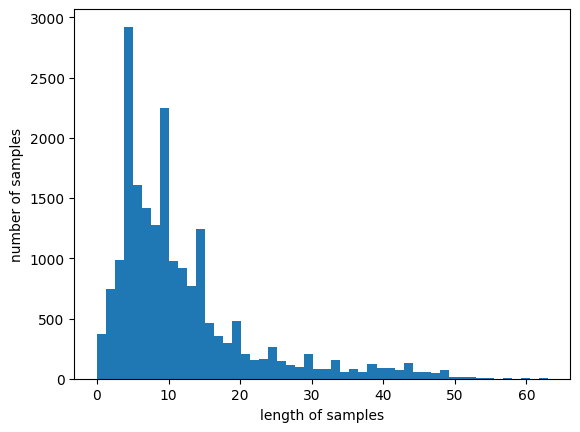

In [32]:
print('리뷰의 최대 길이 :',max(len(review) for review in df_sequences))
print('리뷰의 평균 길이 :',sum(map(len, df_sequences))/len(df_sequences))
plt.hist([len(review) for review in df_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

패딩의 길이를 임베딩 차원이다.

In [33]:
max_len = 30
df_padded = pad_sequences(df_sequences, maxlen = max_len)

## df_padded 데이터셋 설명
- 사용하는 샘플(리뷰 문장) 갯수는 총 9918개이다.
- 각 문장은 총 30개의 토큰(정수 인코딩)로 구성되어 있다.
- 이후 각 단어를 word2vec 처럼 임베딩 공간에서 표현해준다.
- 여기서는 Keras Embedding()의 벡터 차원(256개) 사용할 것이다.
- 따라서, 데이터셋은 9918x30x256을 같는다.

In [34]:
df_padded.shape, df_label.shape

((19754, 30), (19754,))

# 2. MLP로 네이버 영화 리뷰 감성 분류하기

텍스트 데이트를 훈련과 테스트 데이터로 나누기
- 20로 훈련과 테스트로 나누자
- sklearn의 train_test_split을 이용하다.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_padded, df_label, test_size=0.2, shuffle=True, random_state=34)

In [36]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15803, 30) (15803,)
(3951, 30) (3951,)


케라스로 모델을 만들자.
- 긍정과 부정을 분류하는 이진 분류 모델 문제이다.
- MLP의 2개의 층을 이용하자.
- 출력층에는 시그모이드를 사용한다.
- 2차원으로 임베딩된 입력을 1차원 입력을 바꿔주기 위하여 Flatten을 사용

In [37]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

케라스에서 단어 임베딩 Embedding()의 embedding_dim=256

In [38]:
embedding_dim=256
neurons = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
#model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(neurons, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

- EarlyStopping는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료한다.
- ModelCheckpoint를 사용하여 검증데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장한다.
- 훈련 데이터를 20%로 검증데이터로 분리한다.

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [40]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/20
197/198 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.5885 - loss: 0.6609
Epoch 1: val_acc improved from -inf to 0.77634, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.5892 - loss: 0.6602 - val_acc: 0.7763 - val_loss: 0.4670
Epoch 2/20
195/198 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8216 - loss: 0.4062
Epoch 2: val_acc improved from 0.77634 to 0.80955, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.8216 - loss: 0.4059 - val_acc: 0.8096 - val_loss: 0.4113
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8930 - loss: 0.2733
Epoch 3: val_acc did not improve from 0.80955
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.8930 - loss: 0.2733 - val_acc: 0.7960 - val_loss: 0.4451
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9413 - loss: 0.1761
Epoch 4: val_acc did not improve from 0.80955
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.9412 - loss: 0.1761 - val_acc: 0.7903 - val_loss: 0.4998
Epoch 5/20
192/198 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9658 - loss: 0.1078
Epoch 5: val_acc did not improve from 0.80955
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9657 - loss: 0.1078 - val_acc: 0.7833 - val_loss: 0.6109
Epoch 6/20
196/198 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9778 - loss: 0.0671
Epoch 6: val_acc did not improve from 0.80955
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.9777 -

In [41]:
loaded_model = load_model('best_model.h5')

In [42]:
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8197 - loss: 0.4053

 테스트 정확도: 0.8076


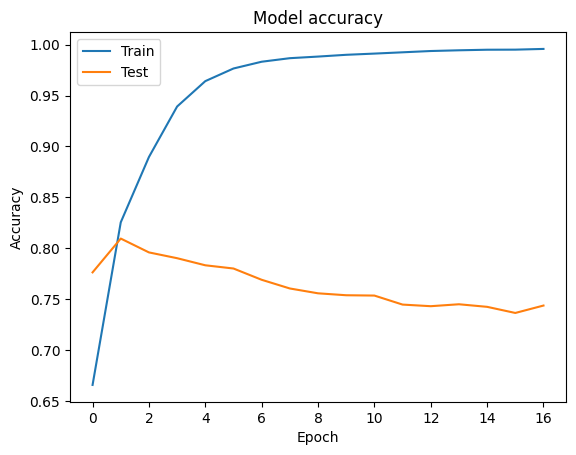

In [43]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

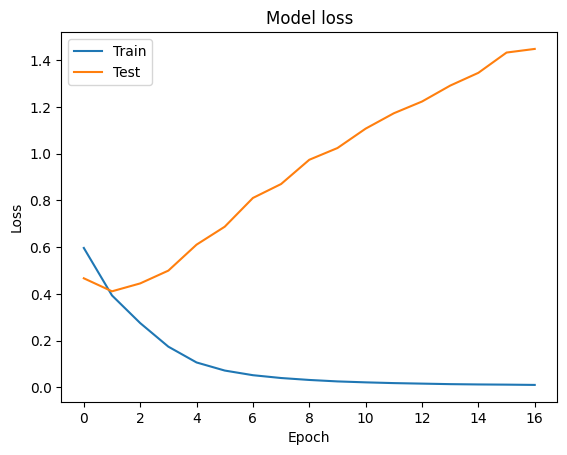

In [44]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 3. 리뷰 예측해보기

In [45]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [46]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
57.26% 확률로 부정 리뷰입니다.



<ipython-input-45-aea673e90f20>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [47]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
85.62% 확률로 부정 리뷰입니다.



<ipython-input-45-aea673e90f20>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [48]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
97.56% 확률로 부정 리뷰입니다.



<ipython-input-45-aea673e90f20>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [49]:
sentiment_predict('감독 뭐하는 놈이냐?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
96.20% 확률로 부정 리뷰입니다.



<ipython-input-45-aea673e90f20>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [50]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
50.47% 확률로 긍정 리뷰입니다.



<ipython-input-45-aea673e90f20>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측
